<a href="https://colab.research.google.com/github/nitsansoffair/IK/blob/main/IK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount.

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Extraction.

In [2]:
import zipfile

from pathlib import Path

# Extract the ZIP file
zip_path = "/content/drive/MyDrive/PhD/BGU/BigData/Project/IK.zip"
extract_path = "/content/audios"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths for video folders
positive_path = Path(extract_path) / "positive"
negative_path = Path(extract_path) / "negative"

Dataset.

In [3]:
import torch
import librosa
import numpy as np

from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, audio_dir, label, sample_rate=16_000, max_duration=20):
        self.audio_dir = Path(audio_dir)
        self.label = label
        self.audio_files = list(self.audio_dir.glob("*.mp3"))

        self.sample_rate = sample_rate
        self.max_duration = max_duration  # in seconds

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = str(self.audio_files[idx])
        y, sr = librosa.load(audio_path, sr=self.sample_rate, duration=self.max_duration)

        # Ensure consistent length (pad or truncate)
        if len(y) < self.sample_rate * self.max_duration:
            y = np.pad(y, (0, self.sample_rate * self.max_duration - len(y)), mode='constant')
        else:
            y = y[:self.sample_rate * self.max_duration]

        # Convert audio waveform to tensor
        audio_tensor = torch.tensor(y, dtype=torch.float32)

        # If your model expects 2D input (batch_size, input_length), ensure the input shape is correct
        # Reshape to shape (1, input_length) for a single sample (e.g., [batch_size, 16000])
        audio_tensor = audio_tensor.unsqueeze(0)  # Add batch dimension

        return audio_tensor, self.label

Split.

In [4]:
from torch.utils.data import random_split, ConcatDataset

# Prepare datasets
positive_dataset = AudioDataset(positive_path, 0)
negative_dataset = AudioDataset(negative_path, 1)

# Combine datasets
full_dataset = ConcatDataset([positive_dataset, negative_dataset])

# Split dataset into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoader with a custom collate function
def collate_fn(batch):
    audios, labels = zip(*batch)

    # Pad all audio features to have the same shape (consistent MFCC length)
    max_len = max(audio.shape[1] for audio in audios)
    padded_audios = [torch.nn.functional.pad(audio, (0, max_len - audio.shape[1])) for audio in audios]

    audios_tensor = torch.stack(padded_audios)
    labels_tensor = torch.tensor(labels)

    return audios_tensor, labels_tensor

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

Model.

In [5]:
import torch.nn as nn

from transformers import Wav2Vec2Model, Wav2Vec2Config

# Define the custom model class
class Wav2Vec2Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(Wav2Vec2Classifier, self).__init__()

        # Load Wav2Vec2Model with no pretrained weights (use the base configuration)
        config = Wav2Vec2Config(hidden_size=768)  # You can change hidden_size based on your needs
        self.wav2vec2 = Wav2Vec2Model(config)

        # The size of the encoder's hidden states
        encoder_output_dim = config.hidden_size

        # Define the classifier (fully connected layer)
        self.fc = nn.Linear(encoder_output_dim, num_classes)

    def forward(self, input_values):
        # Forward pass through Wav2Vec2 model (feature extraction)
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state

        # Take the mean of the hidden states across time steps (for audio classification)
        pooled_output = hidden_states.mean(dim=1)

        # Pass through the fully connected layer for classification
        logits = self.fc(pooled_output)

        return logits

Train blocks.

In [6]:
# Instantiate and test the model
model = Wav2Vec2Classifier(num_classes=2).cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

Hyperparameters.

In [7]:
# Total epochs.
n_epochs = 100

# Report frequency.
report_freq = 10

Train loop.

In [8]:
import torch.optim as optim
import torch.nn as nn

# Assume the model, criterion, optimizer, train_loader, and other variables are already defined

def train_model(model, train_loader, criterion, optimizer, n_epochs, report_freq):
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        loss_epoch = 0  # Initialize loss for the current epoch

        for audios, labels in train_loader:
            # Ensure audios and labels are on the correct device (GPU or CPU)
            audios, labels = audios.cuda(), labels.cuda()

            audios = audios.squeeze(1)

            # Forward pass: Get model predictions
            outputs = model(audios)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization step
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Perform the optimization step

            # Accumulate loss for the epoch
            loss_epoch += loss.item()

        # Print loss at specified intervals
        if epoch % report_freq == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss_epoch:.2f}")

# Example usage of train_model function:
train_model(model.cuda(), train_loader, criterion, optimizer, n_epochs=100, report_freq=10)

Epoch 1, Loss: 23.22
Epoch 11, Loss: 7.35
Epoch 21, Loss: 6.44
Epoch 31, Loss: 4.28
Epoch 41, Loss: 6.11
Epoch 51, Loss: 6.52
Epoch 61, Loss: 5.90
Epoch 71, Loss: 5.64
Epoch 81, Loss: 5.57
Epoch 91, Loss: 5.97


Evaluation.

In [9]:
# Evaluation
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for audios, labels in test_loader:
            audios, labels = audios.cuda(), labels.cuda()

            audios = audios.squeeze(1)

            outputs = model(audios)  # Forward pass with audio data

            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

# Call the evaluation function
evaluate(model, test_loader)

Accuracy: 100.00%


Test.

In [10]:
# Test audio index.
index = 1

In [13]:
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt

# Display a test example
def show_test_example(model, test_loader):
    model.eval()

    audios, labels = next(iter(test_loader))
    audios = audios.squeeze(1)

    audio = audios[index, :].unsqueeze(0).cuda()
    print(audio.shape)

    # audio = audios[0].cpu().numpy()  # Get the first audio sample
    label = labels[index].item()

    # Get the model's prediction
    with torch.no_grad():
        output = model(audio)
        predicted_label = torch.argmax(output, dim=1).item()

    # Convert the audio tensor to a playable format
    waveform = audio  # Assuming mono audio for simplicity

    waveform = waveform.cpu()

    # Display the audio with a listening bar
    ipd.display(ipd.Audio(waveform, rate=16_000))  # Assuming a sample rate of 16 kHz

    # Print the ground truth and prediction
    print(f"Ground Truth: {'Positive' if label == 0 else 'Negative'}, "
          f"Prediction: {'Negative' if predicted_label == 1 else 'Positive'}")

# Call the function to test
show_test_example(model, test_loader)

torch.Size([1, 320000])


Ground Truth: Negative, Prediction: Negative


Visualization.

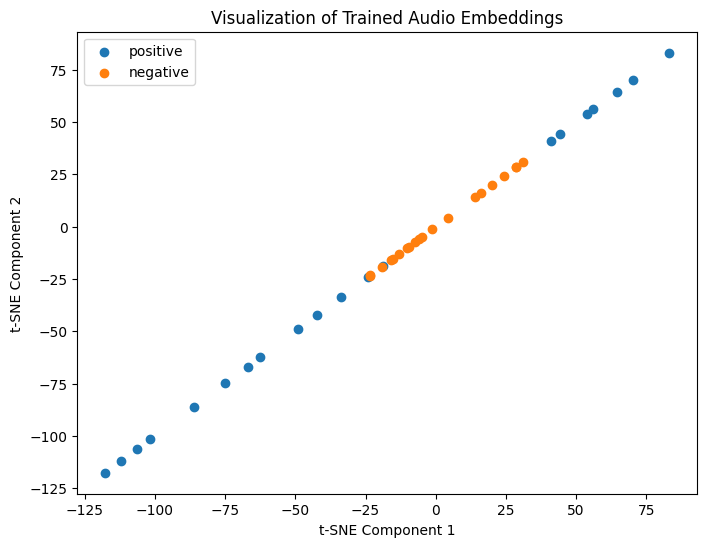

In [65]:
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Define the labels mapping (positive: 0, negative: 1)
labels_mapping = {0: "positive", 1: "negative"}

# Function to visualize embeddings using t-SNE
def visualize_embeddings(model, test_loader, num_samples=100):
    model.eval()

    embeddings = []
    labels = []
    predicted_labels = []

    with torch.no_grad():
        for audios, lbls in test_loader:
            audios = audios.cuda()
            audios = audios.squeeze(1)

            lbls = lbls.cuda()

            # Extract features from the model
            features = model(audios)  # Ensure the model has an embedding layer before final classification
            _, predicted = torch.max(features.data, 1)  # Get the index of the max log-probability

            predicted = torch.reshape(predicted, (-1,))
            predicted = list(predicted)
            predicted = [p.item() for p in predicted]

            embeddings.append(features)
            labels.extend(lbls)
            predicted_labels += predicted

            if len(labels) >= num_samples:  # Limit the number of samples for visualization
                break

    embeddings = torch.cat(embeddings, dim=0)[:num_samples].cpu()
    labels = labels[:num_samples]

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    reduced_embeddings = torch.tensor(tsne.fit_transform(embeddings))

    # Scatter plot of embeddings
    plt.figure(figsize=(8, 6))
    for i, label in labels_mapping.items():
        plt.scatter(reduced_embeddings[:, i], reduced_embeddings[:, i], label=label, alpha=1)

    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("Visualization of Trained Audio Embeddings")
    plt.legend()
    plt.show()

# Run visualization and test example
visualize_embeddings(model, train_loader)